# DoorDash ML Exercise- Predicting Delivery Time

DoorDash is very dependent on how accurate some of it's internal app data is- predictions of delivery time is very impactful on user experience and revenue spend. For this exercise, we will explore the interaction between order and customer information and the time it takes for an order to be delivered.

In [34]:
#import libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math as ma
import scipy.stats as st
import warnings
import pickle
warnings.filterwarnings('ignore')


from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor


from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import BaggingClassifier,GradientBoostingRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno

In [35]:
#import data
train= pd.read_csv('historical_data.csv')
test = pd.read_csv('predict_data.csv')
#train=train.head(1000)
#test=test.head(1000)

In [36]:
print("Train has "+str(train.shape[0])+" observations and "+str(train.shape[1])+" variables")
print("Test has "+str(test.shape[0])+" observations and "+str(test.shape[1])+" variables")

Train has 197428 observations and 9 variables
Test has 54778 observations and 9 variables


In [37]:
train.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


In [38]:
test.head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200


In [39]:
print('Train Min Time is ' +str(min(train['created_at']))+ ' and the max train time is ' +str(max(train['created_at'])))

Train Min Time is 2014-10-19 05:24:15 and the max train time is 2015-02-18 06:00:44


In [40]:
#there is only one observation from 2014 in train- let's drop that one
print(train[pd.to_datetime(train.created_at).dt.year==2015].len())
train=train[pd.to_datetime(train.created_at).dt.year==2015]
print('Train Min Time is ' +str(min(train['created_at']))+ ' and the max train time is ' +str(max(train['created_at'])))

Train Min Time is 2015-01-21 15:22:03 and the max train time is 2015-02-18 06:00:44


In [41]:
print('Test Min Time is ' +str(min(test['created_at']))+ ' and the max test time is ' +str(max(test['created_at'])))

Test Min Time is 2015-02-18 14:50:28 and the max test time is 2015-02-25 05:59:49


## Data Summary- How many missing values?
Can we say they are missing at random and impute them?

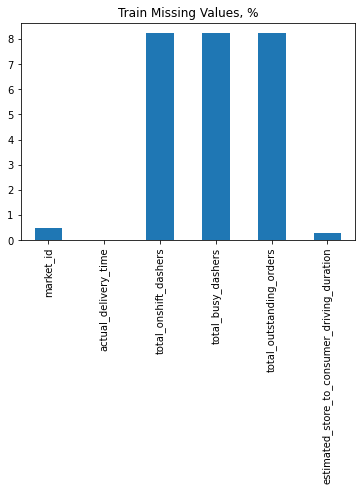

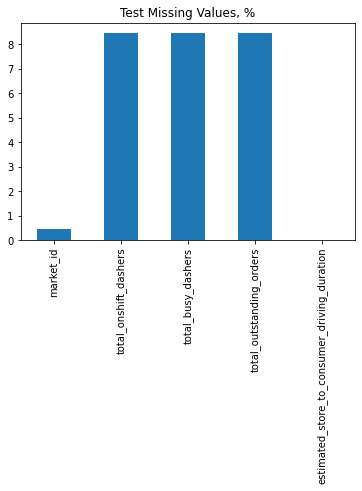

In [42]:
#find percentage of missing values for each column
missing_train = train.isnull().mean()*100
#only look at with missing values because so many columns
missing_train = missing_train[missing_train > 0]
missing_train.plot.bar(title='Train Missing Values, %')
plt.show()


#find percentage of missing values for each column
missing_test = test.isnull().mean()*100
#only look at with missing values because so many columns
missing_test = missing_test[missing_test > 0]
missing_test.plot.bar(title='Test Missing Values, %')
plt.show()



Looks like the propotion is very similar for test and train datasets. As we see below, it looks like the missingness is random- in the matrix graph, missing values are pretty randomized and in the heatmap(only showing missing values), the only high correlations are the ones that are all NA at the same time- this is likely due to the fact that when one piece of order info is missing, all three elements are. Therefore, we can conclude the data is missing at random. This enables us to impute values with multivariate imputation, seen below.

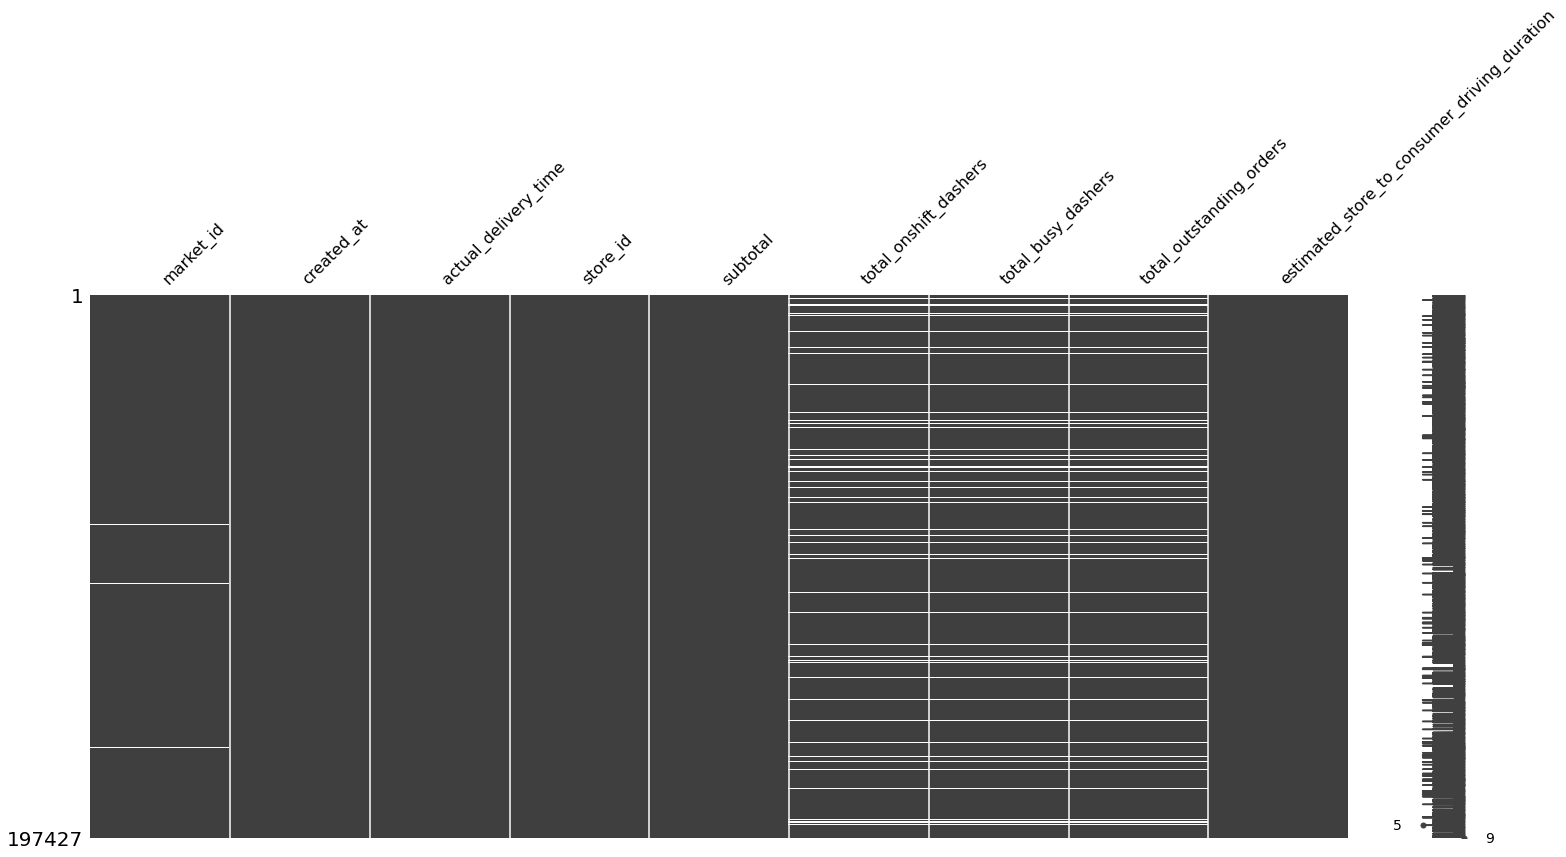

In [43]:
msno.matrix(train);

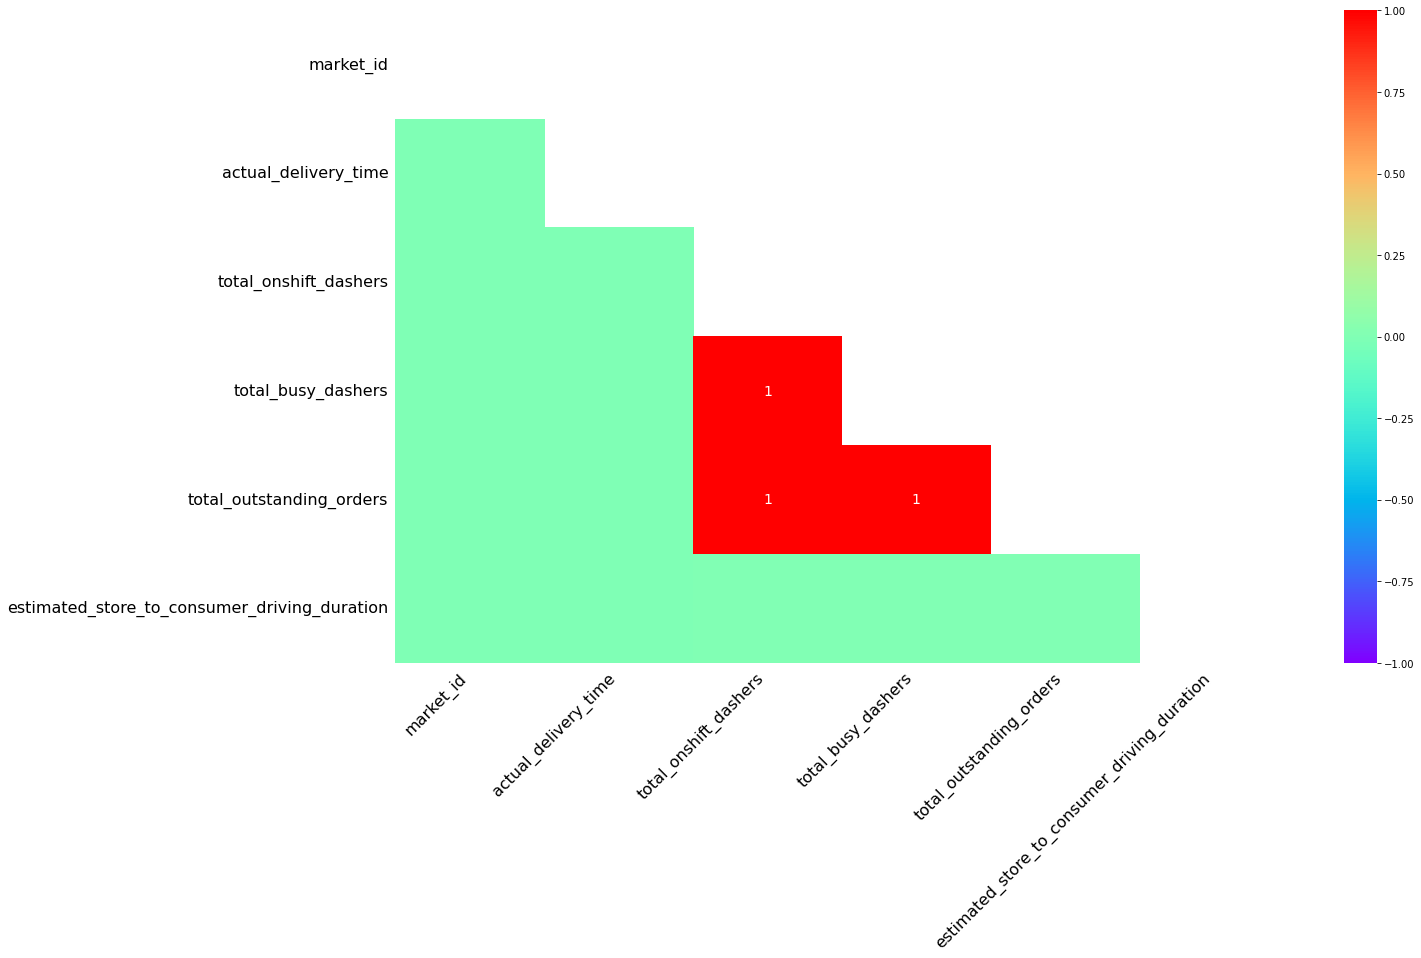

In [44]:
msno.heatmap(train, cmap='rainbow');

### There are some missing values for market_id- let's match them up with store and see if a consensus will improve the missing count

In [45]:
combinedDF=train[['market_id','store_id']].append(test[['market_id','store_id']])
#for every store, let's match them with the most often labeled location for consistency
uniquestores=[*combinedDF['store_id'].unique()]

for s in uniquestores:
    v=combinedDF[combinedDF.store_id==s].market_id.value_counts()
    #update to most common location for that store
    commonlocation=[*v.values]
    if len(commonlocation)>0:
        combinedDF.loc[combinedDF.store_id==s, 'market_id'] = [*v.index][0]
    else:
        combinedDF.loc[combinedDF.store_id==s, 'market_id'] = None
combinedDF=combinedDF.drop_duplicates()

## Preprocessing and Variable Creation

In [46]:
#denote popular store by one that has had more than 100 visits in training period
store_ids=[*train['store_id'].value_counts()[train['store_id'].value_counts()>100].index]

def preprocess(df,combinedDF):
    '''
    Preprocess data and create some variables. Create target variable and also creates some variables based on the date column
    Input: 
    df- dataframe, either train or test
    combinedDF- dataframe with market_id to merge. This will fill in many missing values in this variable
    
    Output: processed dataframe
    
    '''
    #also we can convert some columns to date time and create a few more date attributes

    # Change daytime column to daytime object
    df['created_at'] = pd.to_datetime(df['created_at'])
    
    #don't do this for test data
    if 'actual_delivery_time' in [*df.columns]:
        #we can drop NA from actual_delivery_time, because we can assume these delieveries didn't happen
        df=df.dropna(subset=['actual_delivery_time'])


        df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
        df['Target'] = df['actual_delivery_time'] - df['created_at']
        #we want this time in seconds
        df['Target'] = df['Target'].dt.total_seconds()
        
        
    #now we can create some variables for the creation time- note we won't do this for delivered time since this won't be in the test set
    #add day of week and hour for created_at
    weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

    df['day_of_week'] =df['created_at'].dt.dayofweek#day_name()
    df['weekend'] =0

    df['weekend'] =df.loc[df.day_of_week>=4, 'weekend'] = 1

    df['month'] = df['created_at'].dt.month
    df['hour'] = df['created_at'].dt.hour

    df['Popular_Store']=0
    df.loc[df.store_id.isin(store_ids), 'Popular_Store'] = 1
    
    #join with dataframe with correct location based on store id
    
    df=df.drop(columns=['market_id'])
    df=df.merge(combinedDF,how='left',on='store_id')
    
    #also make is so that on shift dashers is always greater than or equal to busy dashers
    df['total_onshift_dashers']=df[["total_busy_dashers", "total_onshift_dashers"]].max(axis=1)
    
    return(df)
        
train=preprocess(train,combinedDF).reset_index(drop=True)
test=preprocess(test,combinedDF).reset_index(drop=True)


In [47]:
#by combining the store id and market id, we greatly reduce the market_id NAs
train.isnull().sum()

created_at                                          0
actual_delivery_time                                0
store_id                                            0
subtotal                                            0
total_onshift_dashers                           16261
total_busy_dashers                              16261
total_outstanding_orders                        16261
estimated_store_to_consumer_driving_duration      526
Target                                              0
day_of_week                                         0
weekend                                             0
month                                               0
hour                                                0
Popular_Store                                       0
market_id                                           2
dtype: int64

## Multivariate Imputation

- we will assume our data is missing at random
    - for this, we can use iterative imputation
    - a feature with nans is used as the target variable and all others are treated as features
    - using the trained regressor, we can predict any missing values
    - I will not use any variables not available in the testing set, i.e. the time to delivery
    


In [48]:
#remove some columns that don't exist in the other df- created_at is redundant with our created features
def prepare_for_imputation(df):
    train_impute=df.copy()
    if 'actual_delivery_time' in [*train_impute.columns]:
        droppedcols=['created_at','actual_delivery_time','Target']
    else:
        droppedcols=['created_at', 'delivery_id']


    train_impute=train_impute.drop(columns=droppedcols)
    return train_impute

train_impute=prepare_for_imputation(train)
test_impute=prepare_for_imputation(test)

In [49]:
#we will use random forest regressor for imputation
imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=10), random_state=0)
df_train_imp = imputer.fit_transform(train_impute)
df_train_imp = pd.DataFrame(data=df_train_imp, columns = train_impute.columns).reset_index()

df_test_imp=imputer.transform(test_impute)
df_test_imp = pd.DataFrame(data=df_test_imp, columns = test_impute.columns)




In [50]:
def add_back_cols(dforig,df):
    
    if 'actual_delivery_time' in [*dforig.columns]:
        droppedcols=['created_at','actual_delivery_time','Target']
    else:
        droppedcols=['created_at', 'delivery_id']
    for col in droppedcols:
        df[col]=dforig[col]

    
    df['month'] =df['created_at'].dt.month_name()


    df['day_of_week'] =df['created_at'].dt.day_name()
    #df=pd.get_dummies(df, prefix=['weekday','month'])

    #round any imputations of market_id to nearest integer- 
    #there can't be any in between numbers and if it's closest, then 
    #we will assume this is close enough to be the integer to be 
    #considered that market- this happens in relatively few instances,
    #so it is not worth exploring other possibilities right now
    df['market_id']=df['market_id'].round(0)
    
    df['dasher_info_missing'] = np.where(dforig.total_busy_dashers.isnull(), 0, 1)
    
    #also make it so that on shift dashers is always greater than or equal to busy dashers(and greater than 0)
    df['tmp']=1
    df['total_onshift_dashers']=df[["total_busy_dashers","tmp"]].max(axis=1)
    df=df.drop(columns=['tmp'])
    df['total_onshift_dashers']=df[["total_busy_dashers", "total_onshift_dashers"]].max(axis=1)

    return df

train=add_back_cols(train,df_train_imp)
test=add_back_cols(test,df_test_imp)

Now we can see we successfully imputed all NAs and removed cases where delivery time was not available

In [51]:
print(train.isnull().mean()*100)
print('------------------------')
print(test.isnull().mean()*100)



index                                           0.0
store_id                                        0.0
subtotal                                        0.0
total_onshift_dashers                           0.0
total_busy_dashers                              0.0
total_outstanding_orders                        0.0
estimated_store_to_consumer_driving_duration    0.0
day_of_week                                     0.0
weekend                                         0.0
month                                           0.0
hour                                            0.0
Popular_Store                                   0.0
market_id                                       0.0
created_at                                      0.0
actual_delivery_time                            0.0
Target                                          0.0
dasher_info_missing                             0.0
dtype: float64
------------------------
store_id                                        0.0
subtotal                

# Visualizations

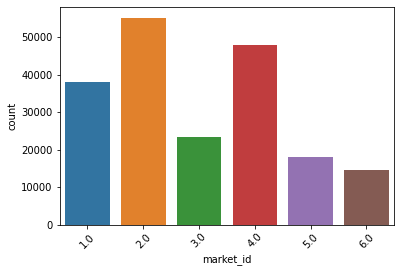

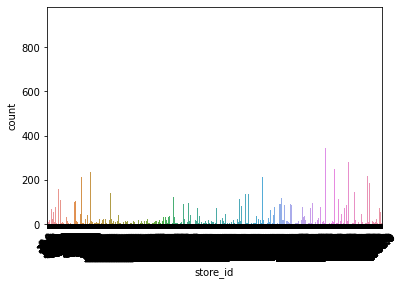

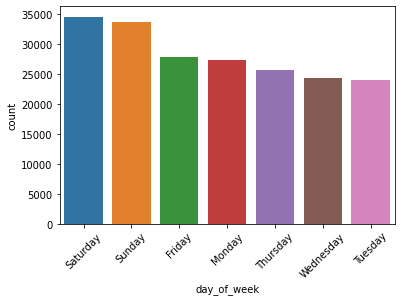

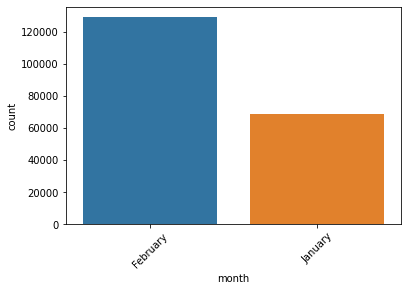

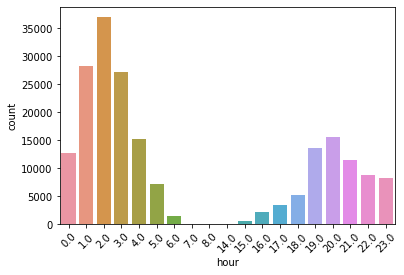

In [52]:
columns = ['market_id','store_id','day_of_week','month','hour']
for i,col in enumerate(columns):
    tmp = train[col].value_counts().to_frame().reset_index()
    tmp.columns = [col,"count"]
    plt.figure(i)
    sns.barplot(tmp[col],tmp["count"])
    plt.xticks(rotation=45)

In [53]:
train.describe()

,index,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,weekend,hour,Popular_Store,market_id,Target,dasher_info_missing
count,197420.000000,197420.000000,197420.000000,197420.000000,197420.000000,197420.000000,197420.000000,197420.0,197420.000000,197420.000000,197420.000000,197420.000000,197420.000000
mean,98709.500000,3530.581248,2682.331380,41.455851,41.434424,57.518689,545.323676,1.0,8.467379,0.427829,2.980043,2865.131294,0.917632
std,56990.389409,2053.498629,1823.109519,30.865943,30.894364,50.699921,219.114096,0.0,8.658799,0.494765,1.524280,1613.285907,0.274925
min,0.000000,1.000000,0.000000,1.000000,-5.000000,-6.000000,0.000000,1.0,0.000000,0.000000,1.000000,101.000000,0.000000
25%,49354.750000,1686.000000,1400.000000,16.000000,16.000000,19.000000,383.000000,1.0,2.000000,0.000000,2.000000,2104.000000,1.000000
50%,98709.500000,3592.000000,2200.000000,35.500000,35.500000,43.300000,543.000000,1.0,3.000000,0.000000,3.000000,2660.000000,1.000000
75%,148064.250000,5299.000000,3395.000000,60.000000,60.000000,81.000000,702.000000,1.0,19.000000,1.000000,4.000000,3381.000000,1.000000
max,197419.000000,6987.000000,27100.000000,154.000000,154.000000,285.000000,2088.000000,1.0,23.000000,1.000000,6.000000,373879.000000,1.000000


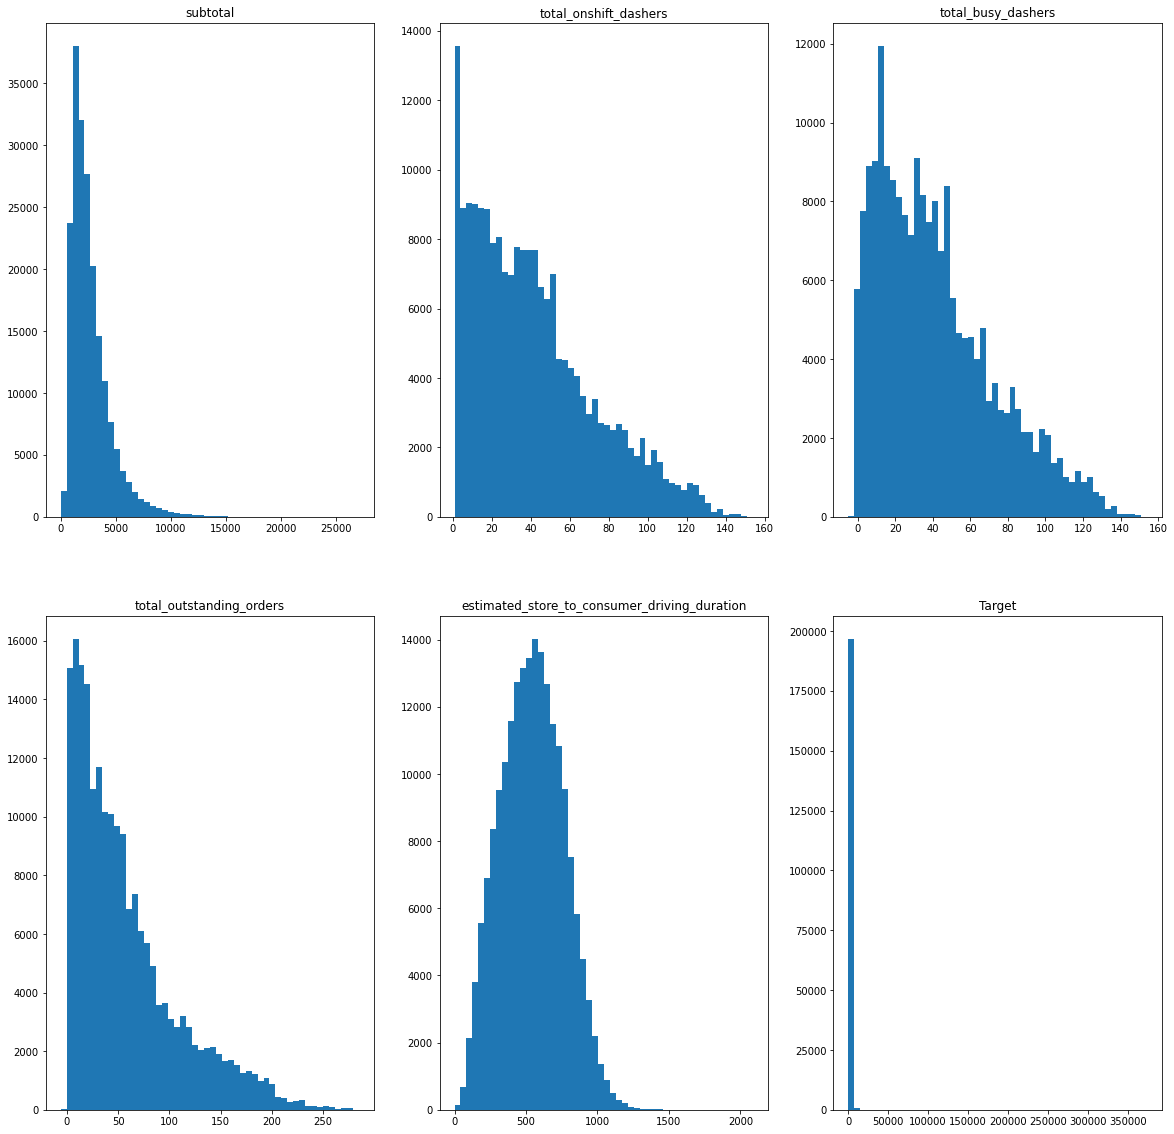

In [54]:
#check Numerical variables distribution
Numerical_column = [ 'subtotal','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration','Target']
fig, axes = plt.subplots(2, 3, figsize=(20, 20))

q=1

for j in Numerical_column:
    plt.subplot(2,3,q)
    plt.hist((train[j]), bins = 50)
    plt.title(j)
    q+=1


### Time Series- Let's look at total counts by date and Order Amount
The order number and amount seem to follow the same trend, but target does not. Perhaps some larger orders or high volume days inflated this exponentially.

(array([735647., 735648., 735649., 735650., 735651., 735652., 735653.,
        735654.]),
 <a list of 8 Text major ticklabel objects>)

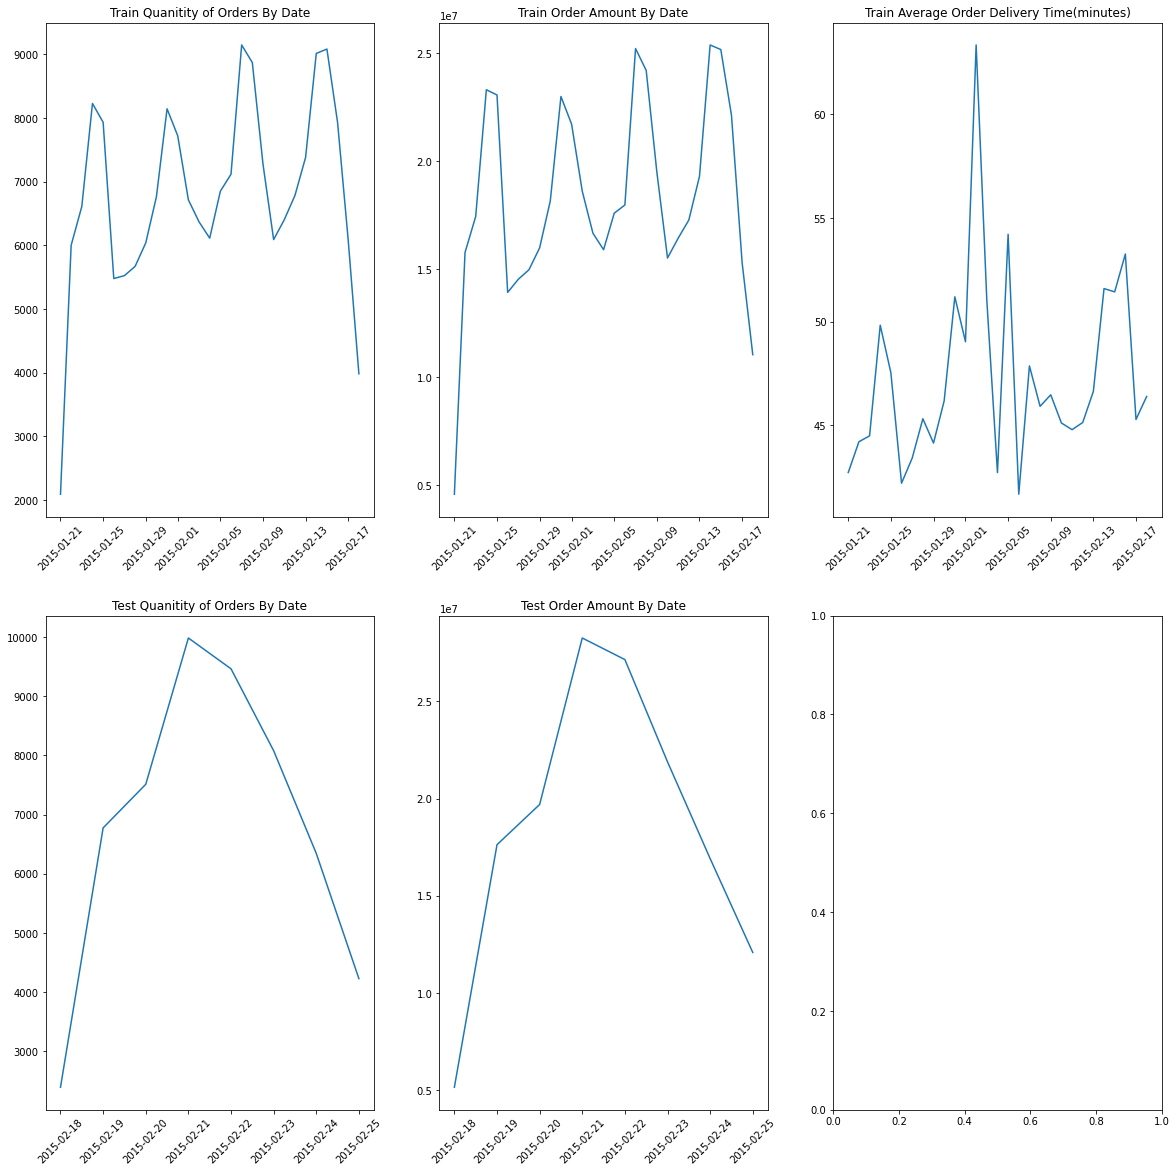

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))
df = train.groupby([train['created_at'].dt.date]).agg({'subtotal':'count'}).reset_index()

plt.subplot(2,3,1)
plt.plot(df['created_at'], df['subtotal'])

plt.title('Train Quanitity of Orders By Date')
plt.xticks(rotation=45)

df = train.groupby([train['created_at'].dt.date]).agg({'subtotal':'sum'}).reset_index()

plt.subplot(2,3,2)
plt.plot(df['created_at'], df['subtotal'])

plt.title('Train Order Amount By Date')
plt.xticks(rotation=45)


df = train.groupby([train['created_at'].dt.date]).agg({'Target':'mean'}).reset_index()

plt.subplot(2,3,3)
plt.plot(df['created_at'], df['Target']/60)

plt.title('Train Average Order Delivery Time(minutes)')
plt.xticks(rotation=45)




df = train.groupby([test['created_at'].dt.date]).agg({'subtotal':'count'}).reset_index()

plt.subplot(2,3,4)
plt.plot(df['created_at'], df['subtotal'])

plt.title('Test Quanitity of Orders By Date')
plt.xticks(rotation=45)


df = test.groupby([test['created_at'].dt.date]).agg({'subtotal':'sum'}).reset_index()

plt.subplot(2,3,5)
plt.plot(df['created_at'], df['subtotal'])

plt.title('Test Order Amount By Date')
plt.xticks(rotation=45)

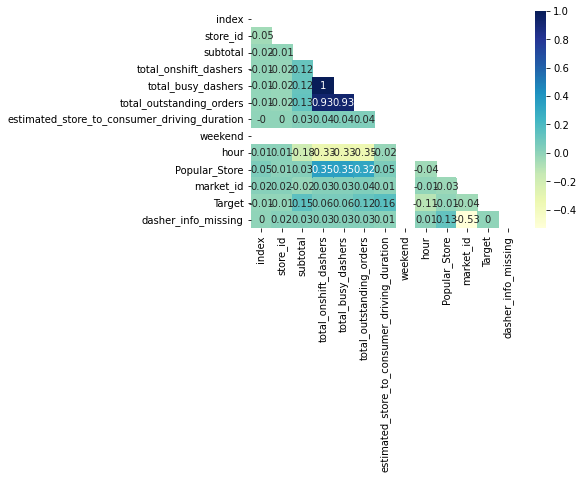

In [56]:
#correlation matrix
corrMatrix = train.corr().round(2)

# creating mask
mask = np.triu(np.ones_like(corrMatrix))
 
# plotting a triangle correlation heatmap
sns.heatmap(corrMatrix, cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
plt.show()

In [57]:
#there are a few orders with huge delivery times- let's cap at two hours
print(sum((train['Target']/3600)>2))

#also make sure orders take at least 10 minutes to deliver from order- otherwise, implausible 
sum((train['Target']/60)<10)

1089


27

Based on above, let's fix some of the columns- less than 0 shouldn't be allowed
Also there are some really long and short order times. However, there are enough that we don't want to remove them. This could highly bias the test set since there are plenty of them.

In [58]:

def fix_vars(df,store_ids):
    cols=['total_onshift_dashers','total_busy_dashers','total_outstanding_orders']
    for j in cols:
        df[j].values[df[j] <0] = 0
    return df

train=fix_vars(train,store_ids)
test=fix_vars(test,store_ids)

If we plot the target by time, there are relatively similar distributions by day-
no one day has all the large order times

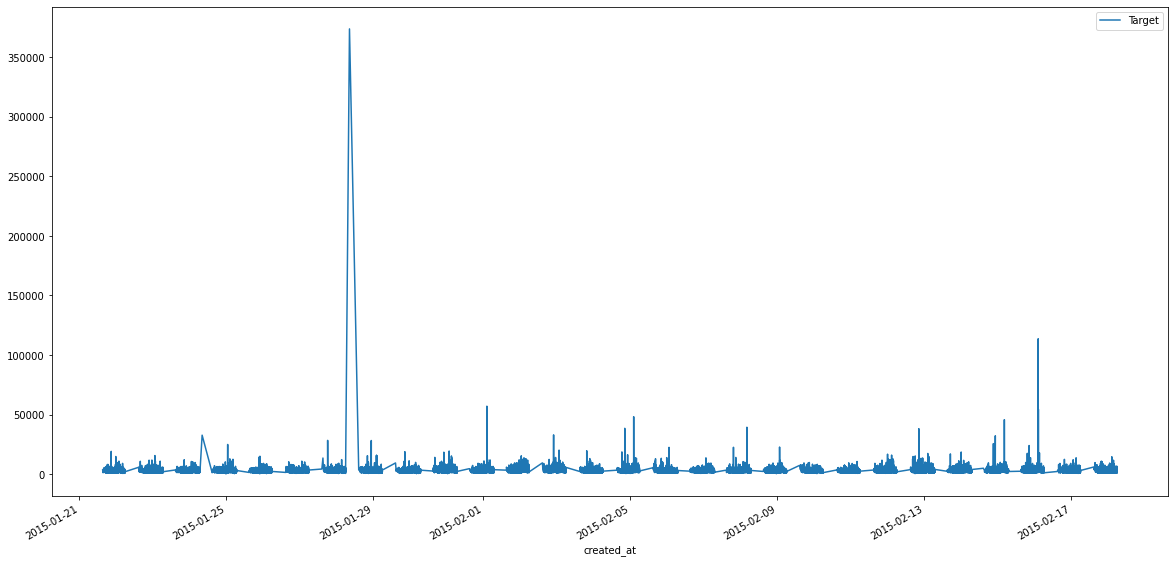

In [59]:
train.groupby([train["created_at"]]).mean()[['Target']].plot(legend=True, figsize=(20,10))

Hour is also relatively even- with a bit of a bump right before the dinner rush

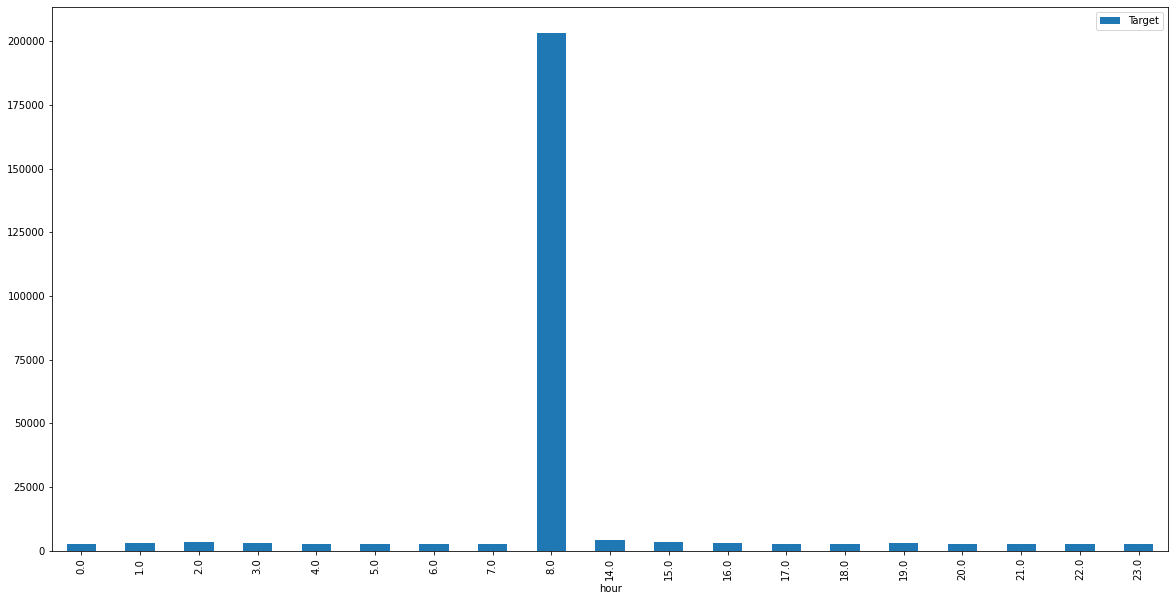

In [60]:
#look at hour and delivery time associated with it
train.groupby(["hour"]).mean()[['Target']].plot.bar(legend=True, figsize=(20,10))

There is some variation if we look at order by market and hour, but this may be due to sample size and dynamics of each market(i.e. maybe late night is more prevalent with market 1). No one market dominates accross all time indicies so we won't do any more here.

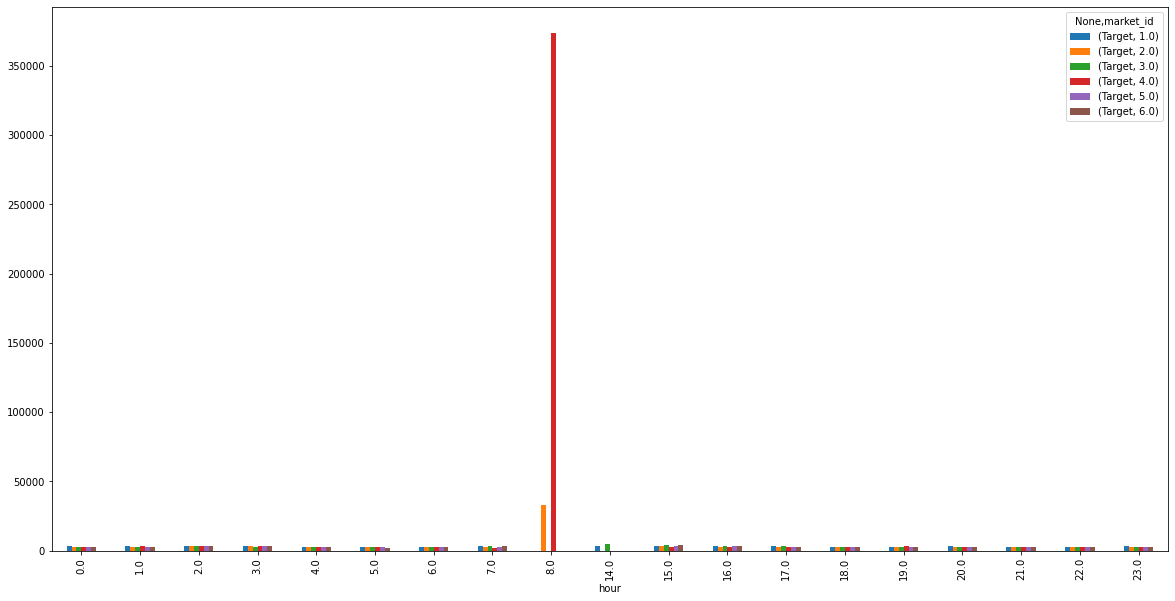

In [61]:
train.groupby(["hour",'market_id']).mean()[['Target']].unstack('market_id').plot.bar(legend=True, figsize=(20,10))

Finally we will look at how some metrics vary with the target variable in a scatter plot. It seems like most high order times occur when there are very few on shift drivers. Also high order times when most or all of available dashers are picking up an order. There are also a few outliers- mostly at 8am- maybe this is when stores are closed?


Text(0, 0.5, 'Order Time (sec)')

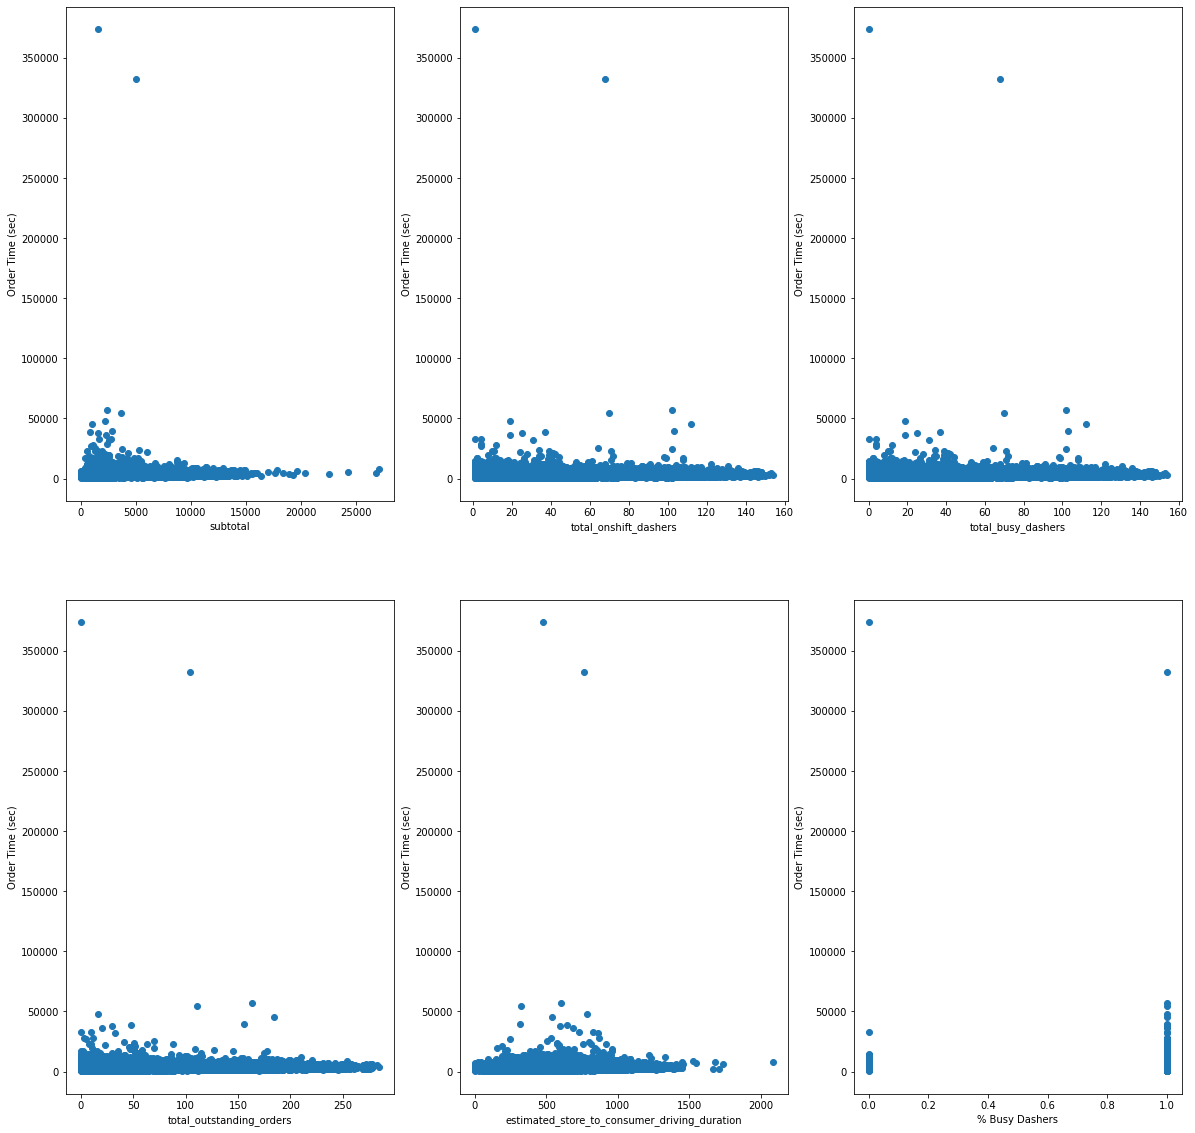

In [62]:
columns = [ 'subtotal','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration']

fig, axes = plt.subplots(2, 3, figsize=(20, 20))
q=1
for col in (columns):
    plt.subplot(2,3,q)
    plt.scatter(train[col],train['Target'])
    #plt.plot(train[col],train['Target'])
    plt.xlabel(col)
    plt.ylabel('Order Time (sec)')
    q=q+1

plt.subplot(2,3,q)
plt.scatter(train['total_busy_dashers']/train['total_onshift_dashers'],train['Target'])
plt.xlabel('% Busy Dashers')
plt.ylabel('Order Time (sec)')


### Let's Look at Some Transformations
- maybe Log transformation could be helpful(first 4 graphs)
- also, without the outliers, target looks nice and normally distributed

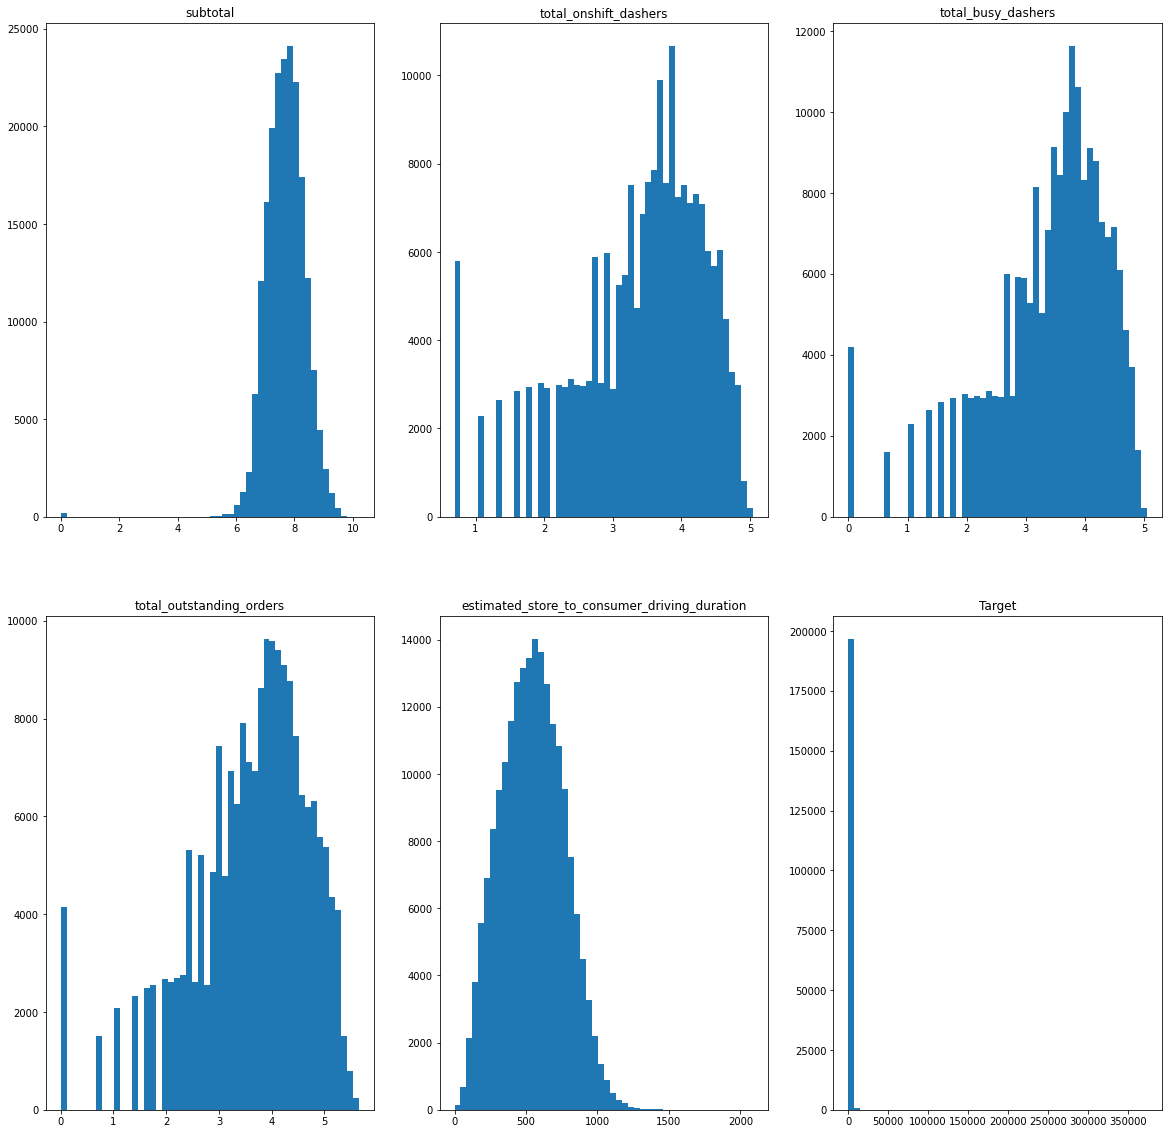

In [63]:
#check Numerical variables distribution
Numerical_column = [ 'subtotal','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration','Target']
fig, axes = plt.subplots(2, 3, figsize=(20, 20))

q=1

for j in Numerical_column:
    plt.subplot(2,3,q)
    v=train[j]
    if q<=4:
        v=np.log1p(v)
    plt.hist(v, bins = 50)
    plt.title(j)
    q+=1

If we look at the number disribution of the Target variable over three hours, there are still quite a few instances, so we cannot simply drop it.

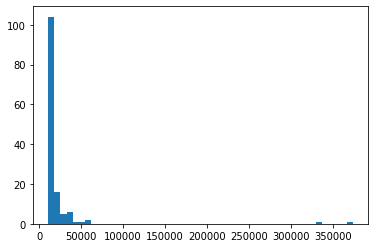

In [64]:
plt.hist(train.Target[train.Target>=(3*3600)],bins=50)
plt.show()

## Final Transformations

- sums for last 15 minutes and hour: order totals and orders received by market
- outstanding orders per dasher could be predictive in that it will tell us how many orders would need to be completed by dasher to finish all orders- analagous to how busy we are
- busy dashers- ratio of busy to all dashers currently

In [ ]:
def order_metrics(df):
    lasthr=[]
    last15=[]
    sum15list=[]
    sum60list=[]
    #orders in last 15 minutes & hour
    for j in range(len(train)):
        time1=pd.to_datetime(df.created_at[j])
        hourago=pd.to_datetime(df.created_at[j]) + pd.Timedelta(hours=-1)
        minutesago15=pd.to_datetime(df.created_at[j]) + pd.Timedelta(minutes=-15)

        #also group by market
        sum1=sum((pd.to_datetime(df.created_at)<=time1)&(pd.to_datetime(df.created_at)>hourago)&(df.market_id==train.market_id[j]))
        lasthr.append(sum1)
        sum1=sum((pd.to_datetime(df.created_at)<=time1)&(pd.to_datetime(df.created_at)>minutesago15)&(df.market_id==train.market_id[j]))
        last15.append(sum1)
        sum15=df.subtotal[((pd.to_datetime(df.created_at)<=time1)&(pd.to_datetime(df.created_at)>minutesago15)&(df.market_id==train.market_id[j]))]
        sum15=sum(sum15.values)
        sum15list.append(sum15)

        sum60=df.subtotal[((pd.to_datetime(df.created_at)<=time1)&(pd.to_datetime(df.created_at)>hourago)&(df.market_id==train.market_id[j]))]
        sum60list.append(sum60)


    df['orderslasthr']=lasthr
    df['orderslast15min']=last15
    df['subtotallast15']=sum15list
    df['subtotallasthr']=sum60list



    df['outstanding_orders_per_dasher']=df['total_outstanding_orders']/(df['total_onshift_dashers'])
    df['busydashers']=df['total_busy_dashers']/df['total_onshift_dashers']
    df['availdashers_last15ordersratio']=(df['total_busy_dashers']-df['total_onshift_dashers'])/df['orderslast15min']
    df['availdashers_lasthrordersratio']=(df['total_busy_dashers']-df['total_onshift_dashers'])/df['orderslasthr']

    return df
train=order_metrics(train)
test=order_metrics(test)

In [ ]:
train.head()

### Additional Things to compute:

A few binned and dummy variables to compute:
- hour need to be binned instead of treated as numeric since the difference between 1 and 2am doesn't mean the same as 7 to 8pm 
- also can do this for subtotal
- create dummy variables for categorical variables

In [ ]:
def Final_Transform(df):
    cols=[ 'subtotal','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders']

    
    #for j in cols:
        #df[j]=np.log1p(df[j])
        
    
    df['market_id']=df['market_id'].astype("category")
    
    create_hr_bin = ['10pm-1am','2am-7am', '8am','9am-5pm','6pm-9pm', '101pm-1am']
    df['hour_binned'] = pd.cut(df['hour'],[0,1,7,8,17,21,23],labels=create_hr_bin)
    df.loc[df['hour_binned']=='101pm-1am','hour_binned']='10pm-1am'

    create_hr_bin = ['under10','10-30', '30-50', '50more']
    df['subtotalbinned'] = pd.cut(df['hour'],[0,1000,3000,5000,100000000000],labels=create_hr_bin)


    df['weekend']=df['weekend'].astype("category")


    df=pd.get_dummies(df)
    df=df.drop(columns=["hour_binned_101pm-1am"])
    
    return df

train=Final_Transform(train)
test=Final_Transform(test)

In [ ]:
train.columns

In [ ]:
train.to_pickle('train.pickle')
test.to_pickle('test.pickle')

# Modeling
I will split by date instead of random so because the test set is a completely different set of date values. This will ensure that the holdout set mimics what my performance will be. 

In [ ]:
train = pd.read_pickle('train.pickle')
test = pd.read_pickle('test.pickle')

In [ ]:
droppedcols=['index','hour','store_id','created_at','actual_delivery_time']

df_train=train.sort_values('created_at').copy()

df_train=df_train.drop(columns=droppedcols)

df_test=test.sort_values('created_at').copy()


train_set, test_set= np.split(df_train, [int(.8 *len(df_train))])
#less than two hours
#train_set = train_set[train_set['Target']<=(2*3600)]
#train_set = train_set[train_set['Target']>=(10*60)]
        
y_train2 = train_set['Target']
y_holdout2 = test_set['Target']

X_train2=train_set.drop(columns=['Target'])
X_holdout2=test_set.drop(columns=['Target'])

size=.9
X_train, X_test2, y_train, y_test2 = train_test_split(X_train2, y_train2, test_size=size,random_state=109)  
X_holdout, X_test22, y_holdout, y_test22 = train_test_split(X_holdout2, y_holdout2, test_size=size,random_state=109)  
#y_train=y_train2
#y_holdout=y_holdout2
#X_train=X_train2
#X_holdout=X_holdout2




# Finding Common columns
commoncols=[*np.intersect1d(X_train.columns, test.columns)]
X_test=df_test[commoncols]

#replicate columns if not in test
i1 = X_train.columns
i2 = X_test.columns
col=i1[~i1.isin(i2)]
for j in col:
    X_test[j]=0
    
#X_test['month_January']=0
X_test=X_test[X_train.columns]
cols=X_train.columns
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_holdout = scale.transform(X_holdout)
X_test = scale.transform(X_test)


X_train=pd.DataFrame(X_train)
X_train.columns=cols
X_holdout=pd.DataFrame(X_holdout)
X_holdout.columns=cols
X_test=pd.DataFrame(X_test)
X_test.columns=cols


# Split into training and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
#sum(test_set['Target']>=(9*60*60))

### Define Some Error functions
These will return error metrics such as mean absolute error and mean squared error while also fitting a model we input

In [ ]:
#performance functions 
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def error(actual,forecast,name):
    
    return pd.DataFrame({'MAE':[mean_absolute_error(actual, forecast).round(2)],'MAPE': [mape(actual,forecast).round(2)],'RMSE': [np.sqrt(mean_squared_error(actual,forecast)).round(2)]},index=pd.Series([name]))

def model_fit(model):
    # Fit it to the training data
    model.fit(X_train, y_train)

    # Predict the labels for the training data X: y_pred
    y_train_pred = model.predict(X_train)

    # Predict and print the label for the new data point X_new
    y_holdout_pred = model.predict(X_holdout)

    print(error(y_train, y_train_pred,'Train'))
    print(error(y_holdout, y_holdout_pred,'Holdout'))
    return np.sqrt(mean_squared_error(y_holdout,y_holdout_pred)).round(2)

### Model Fitting

In [ ]:
# Create Linear Regression
model = LinearRegression()

model_fit(model)

In [ ]:
#lasso regression
model = linear_model.Lasso(alpha=0.1)

model_fit(model)

In [ ]:
#Elastic Net
# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net(parameter from grid search)
model = ElasticNet(l1_ratio=0.89655)

# Setup the GridSearchCV object: gm_cv
#model = GridSearchCV(elastic_net, param_grid, cv=5)
#model.best_params_

model_fit(model)

In [ ]:
# Random Forest
model=RandomForestRegressor(n_estimators = 1000, 
                                #max_depth=max_depth,
                                max_features='sqrt',random_state = 0)
model_fit(model)
model

In [ ]:
features=15
important=np.argsort(np.abs(model.feature_importances_)).ravel()

plt.barh(range(features), model.feature_importances_.ravel()[important[-features:]])
plt.yticks(range(features), X_train.columns[important[-features:]]);
#X_train

In [ ]:
model=GradientBoostingRegressor( verbose=False,random_state=126)  
model_fit(model)

model

In [ ]:
#bagging
from sklearn.tree import DecisionTreeClassifier

# Import BaggingClassifier
from sklearn.ensemble import BaggingRegressor

# Instantiate dt
dt = RandomForestRegressor(n_estimators = 1000, 
                                #max_depth=max_depth,
                                max_features='sqrt',random_state = 0)


# Instantiate bc
bc = BaggingRegressor(base_estimator=dt, n_estimators=1000, random_state=1)
model_fit(model)

### model is overfitting, I will try to change these:
- n_estimators: The more trees, the less likely the algorithm is to overfit. The lower this number, the closer the model is to a decision tree, with a restricted feature set.
- max_features: This defines how many features each tree is randomly assigned. 
- max_depth: This parameter will reduce the complexity of the learned models, lowering over fitting risk. 
- min_samples_leaf: This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.



In [ ]:
rmse=1000000
for max_features in ['auto','sqrt']:
    for min_samples_leaf in [1,2,3, 4]:
        for min_samples_split in [2,4,6]:
            for max_depth in [None,4,8,12]:
                    model=RandomForestRegressor(n_estimators = 1000, 
                                    max_features=max_features,
                                    min_samples_leaf=min_samples_leaf,
                                    min_samples_split=min_samples_split,
                                    bootstrap=bootstrap,random_state = 0)
                    f={"max_features":max_features,"min_samples_leaf":min_samples_leaf,
                              "min_samples_split":min_samples_split,
                      'max_depth':max_depth}
                    print(f)
                    m=model_fit(model)
                    if m<rmse:
                        rmse=m
                        features=f
                

In [ ]:
# Let's do Random Forest Grid Search

model_grid=RandomForestRegressor( random_state = 0)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [1,2,3, 4],
    'min_samples_split': [2,4,6],
    'n_estimators': [100,500,1000,2000],
    'bootstrap': [True, False]
}

model_grid = GridSearchCV(model_grid, param_grid, cv=5)

# Fit it to the training data
model_grid.fit(X_train, y_train)

# Predict the labels for the training data X: y_pred
y_train_pred = model_grid.predict(X_train)

# Predict and print the label for the new data point X_new
y_holdout_pred = model_grid.predict(X_holdout)

print(error(y_train, y_train_pred,'Train'))
print(error(y_holdout, y_holdout_pred,'Holdout'))